# Part 1: computing the time pedestal and the trajectories with ambiguity

In [21]:
import numpy as np 
import pandas as pd
import time 
import timeit
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn

# Recap


The previous steps of the algorithm give us a pandas dataframe of the same format of the starter dataframe, with the new columns event, time, detector and layer. At the end of all calculations we dropped all the events that satify this requirements:

* there are less than 3 layers activated
* there are more than one hit in a single layer

The first requirement is trivial: with only two layers activated (i.e two cells acrivated) every couple of points can be a line and the left/right ambiguity is not solvable. The second requirment is very strong and belong to it two types of events:

* events where a single cell (adjacent cell) has actived multiple times (in the same event)
* events where cells are activated in the same event somewhere far from the main pattern of cells

In the first case we have to choose wich of the activations of cell accept. This must be done during the interpolation
accepting the hits that give a better result, but doing this, for probabilistic reasons, we increase the risk of false positive lines. So this computation can be done but the result must be interpreted in a different way from the rest of analysis. In the second case we can consider the cells far from the main pattern as some electronic error and simply drop them. We will not do this, but the algorithm can be of course impemented for accomplishing to this task.
Another operation that can be removed is the requirment that for every event we keep only the hits in a same detector, other hits that are less than the previous and are in another detector have been removed.

We cut all these events because using pandas, groupby and all the functions of groupy is computationally expensive, so adding more operations for keeping more hits can make the execution time huge.

We recall that this analysis is done only on the file '.../Run00260/data_000000.txt' and all the results holds for this dataset. 

In [22]:
#see at the end
start = time.time()

# Calculating time pedestal and drift time

For first we import the dataframe produced from the algorithm until now. We use ```.astype({"ORBIT_CNT":np.int64})```
for making the orbit number an integer again and distinguishing graphically them.

In [23]:
dataset = pd.read_csv("dati_LS1.csv").astype({"ORBIT_CNT":np.int64})
display(dataset)

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,13.0,1897417007,445.0,24.0,11145.000000,3.0,4.0,1.0
1,14.0,1897417007,450.0,9.0,11257.500000,3.0,2.0,1.0
2,16.0,1897417007,452.0,17.0,11314.166667,3.0,1.0,1.0
3,139.0,1897417007,454.0,0.0,11350.000000,0.0,0.0,1.0
4,15.0,1897417007,458.0,9.0,11457.500000,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...
142915,55.0,1920940194,325.0,4.0,8128.333333,3.0,3.0,1.0
142916,56.0,1920940194,327.0,22.0,8193.333333,3.0,1.0,1.0
142917,139.0,1920940194,329.0,0.0,8225.000000,0.0,0.0,1.0
142918,54.0,1920940194,331.0,20.0,8291.666667,3.0,2.0,1.0


Until now, from 1 292 126 hits we accepted 144 033 hits. 

We can now calculate the time pedestal and drift time. Physically what we are going to do makes no sense: the electronic trigger (TDC_CHANNEL 139) is not a scintillator and for this reason we will have negative drift times. If the trigger was a scintillator the negative drift time would make no sense and we should remove them. But since we are treating the electronic trigger as a scintillator and this makes already no physical sense we will consider negative drift times in absolute value just for having more data.

So we will set the time of the electronic trigger (also recognizable for detector value equal to 0) of each event as the time pedestal and we will subtract to it all the hits in the event to obtain the drift time.

In [24]:
df = dataset.copy() 

df["TIME_PEDESTAL"] = np.nan #this value will remains for the triggers

def assign_time_pedestal(group) :
    t0 = group["TIME"][group.DETECTOR == 0].values #we already know there are a single trigger for event (otherwise we have to add .min())
    group["TIME_PEDESTAL"][group.DETECTOR != 0] = t0 
    return group

df = df.groupby(['ORBIT_CNT',"EVENT"],group_keys=False)\
                   .apply(assign_time_pedestal)\
                   .reset_index()\
                   .drop(['index'],axis=1) 

df["DRIFT_TIME"] = np.abs(df.TIME.values - df.TIME_PEDESTAL) #we recall the absolute value ha no physics sense
df["X"] = 42/(2*390)*df.DRIFT_TIME #from time to space, 42/(2*390) is the drift velocity expressed in mm/ns
df

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT,TIME_PEDESTAL,DRIFT_TIME,X
0,13.0,1897417007,445.0,24.0,11145.000000,3.0,4.0,1.0,11350.0,205.000000,11.038462
1,14.0,1897417007,450.0,9.0,11257.500000,3.0,2.0,1.0,11350.0,92.500000,4.980769
2,16.0,1897417007,452.0,17.0,11314.166667,3.0,1.0,1.0,11350.0,35.833333,1.929487
3,139.0,1897417007,454.0,0.0,11350.000000,0.0,0.0,1.0,NaN,NaN,NaN
4,15.0,1897417007,458.0,9.0,11457.500000,3.0,3.0,1.0,11350.0,107.500000,5.788462
...,...,...,...,...,...,...,...,...,...,...,...
142915,55.0,1920940194,325.0,4.0,8128.333333,3.0,3.0,1.0,8225.0,96.666667,5.205128
142916,56.0,1920940194,327.0,22.0,8193.333333,3.0,1.0,1.0,8225.0,31.666667,1.705128
142917,139.0,1920940194,329.0,0.0,8225.000000,0.0,0.0,1.0,NaN,NaN,NaN
142918,54.0,1920940194,331.0,20.0,8291.666667,3.0,2.0,1.0,8225.0,66.666667,3.589744


# Filtering again

Now we have to remove all the hits that have a drift time larger than the $T_{Max}$. Assuming an uniform error of 25 ns for each time (trigger and not) we have to consider $T_{Max}$ plus the experimental error. After this we have to check again that every events has at least 3 layer activated.

In [25]:
Tmax = 390
experimental_time_uncertainty = 50 #25*2 
T = Tmax + experimental_time_uncertainty


print("max drift time within acceptability window:",df[df.DRIFT_TIME < T].DRIFT_TIME.max())


def cut(group):
    if group.shape[0] > 3 : return group 
    else : return None

#filter dataset by length                          
df = df.groupby(['ORBIT_CNT','EVENT'],group_keys=False).apply(cut)\
                                            .dropna()\
                                            .reset_index()\
                                            .drop(['index'],axis=1)
df 

max drift time within acceptability window: 425.0


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT,TIME_PEDESTAL,DRIFT_TIME,X
0,13.0,1897417007,445.0,24.0,11145.000000,3.0,4.0,1.0,11350.0,205.000000,11.038462
1,14.0,1897417007,450.0,9.0,11257.500000,3.0,2.0,1.0,11350.0,92.500000,4.980769
2,16.0,1897417007,452.0,17.0,11314.166667,3.0,1.0,1.0,11350.0,35.833333,1.929487
3,15.0,1897417007,458.0,9.0,11457.500000,3.0,3.0,1.0,11350.0,107.500000,5.788462
4,89.0,1897417267,300.0,27.0,7522.500000,2.0,4.0,1.0,7825.0,302.500000,16.288462
...,...,...,...,...,...,...,...,...,...,...,...
114051,19.0,1920940163,1449.0,2.0,36226.666667,3.0,3.0,1.0,36075.0,151.666667,8.166667
114052,55.0,1920940194,325.0,4.0,8128.333333,3.0,3.0,1.0,8225.0,96.666667,5.205128
114053,56.0,1920940194,327.0,22.0,8193.333333,3.0,1.0,1.0,8225.0,31.666667,1.705128
114054,54.0,1920940194,331.0,20.0,8291.666667,3.0,2.0,1.0,8225.0,66.666667,3.589744


# Adding cell column

Now we want to stop adopting the TDC_CHANNEL convention for finding the cells and assign a column value for each cell in each layer. For every layer each consecutive column have a TDC_CHANNEL larger than 4 with respect to the previous column. For example the ordered (from left to right) cells of the 4th (from below to above) layer have TDC_CHANNEL = 1, 5, 9, 13, ..., 61. So for mapping this TDC_VALUES values to the number of consecutive cell in the layer 1, 2, 3, ..., 16 we have just to add to the list `[1,5,...,61]` the value 3 and divide by 4. The value 3 is for the 4th layer. For the other layers we have to add different values reported below:

* 1st layer: 0
* 2st layer: 2
* 3st layer: 1
* 4st layer: 3

We apply the function `minus64` for mapping the TDC_CHANNEL in the range `[65,128]` to the range `[1,64]` and so using the convention above. For mapping each layer to the correct value to sum to the TDC_CHANNEL we apply the function `BarycentricInterpolator([x1,x2,x3,x4],[y1,y2,y3,y4])` from `scipy.interpolate` that it is an interpolation that gives a 3 degree polynomial function (4 degrees of freedom) used for the mapping.

In [26]:
#The function below is like the operation y = x%64 but for x equal to 64 will be 64 not 0
def minus64(x):
    if x < 65: 
        return x
    else:
        return x - 64



df["COLUMN"] = ((df['TDC_CHANNEL'].apply(minus64) #normalize the TDC_CHANNEL to 1-64 range
                 + interpolate.BarycentricInterpolator([1,2,3,4],[0,2,1,3])(df["LAYER"])) #this raw return the value to sum to the TDC_CHANNEL
                / 4).astype(int)
df

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT,TIME_PEDESTAL,DRIFT_TIME,X,COLUMN
0,13.0,1897417007,445.0,24.0,11145.000000,3.0,4.0,1.0,11350.0,205.000000,11.038462,4
1,14.0,1897417007,450.0,9.0,11257.500000,3.0,2.0,1.0,11350.0,92.500000,4.980769,4
2,16.0,1897417007,452.0,17.0,11314.166667,3.0,1.0,1.0,11350.0,35.833333,1.929487,4
3,15.0,1897417007,458.0,9.0,11457.500000,3.0,3.0,1.0,11350.0,107.500000,5.788462,4
4,89.0,1897417267,300.0,27.0,7522.500000,2.0,4.0,1.0,7825.0,302.500000,16.288462,7
...,...,...,...,...,...,...,...,...,...,...,...,...
114051,19.0,1920940163,1449.0,2.0,36226.666667,3.0,3.0,1.0,36075.0,151.666667,8.166667,5
114052,55.0,1920940194,325.0,4.0,8128.333333,3.0,3.0,1.0,8225.0,96.666667,5.205128,14
114053,56.0,1920940194,327.0,22.0,8193.333333,3.0,1.0,1.0,8225.0,31.666667,1.705128,14
114054,54.0,1920940194,331.0,20.0,8291.666667,3.0,2.0,1.0,8225.0,66.666667,3.589744,14


# Plotting final hits

Now that we have our final dataset of candidate trajectories we can plot them. For doing this (in the function `event_plot`) we have to assign a cartesian coordianate for each hit. We do it inside the function taking as origin the left-bottom vertix of the 1st cell of the 1st layer.

In [27]:
def event_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    #dimensions of one cell
    dx = 42
    dy = 13
    
    x = [] #x coordinate of the hit
    y = [] #y coordinate of the hit
    for i in range(len(event)):
        hit = event.iloc[i] 
        y1 = dy * (hit.LAYER-1/2)
        y.append(y1) 
        y.append(y1) #two times because for each hit we have to possibile coordinates (left/right ambiguity) with the same y value

        
        if hit.LAYER % 2 != 0 : #just look the figure below to see that in this case we need to subtract 1/2 to obtain the center
            x1 = dx * (hit.COLUMN - 1/2) + hit.X #right hypotesis
            x2 = dx * (hit.COLUMN - 1/2) - hit.X #left hypotesis
            x.append(x1)
            x.append(x2)
        else : #just look the figure also in this case to convince yourself 
            x1 = dx * hit.COLUMN + hit.X 
            x2 = dx * hit.COLUMN - hit.X 
            x.append(x1)
            x.append(x2)
            

    #draw the detector
    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13) 
    
    #we will use the function patches.Rectangle from matplotlib to draw the rectangles of the cells, the function
    #will need as argument the left_bottom vertix of each cell
    x_1 = x_3 = np.arange(16)*dx 
    x_2 = x_4 = x_1 + dx/2
    [y_1, y_2, y_3, y_4] = np.arange(4)*dy 
    
    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(x,y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    return ax1

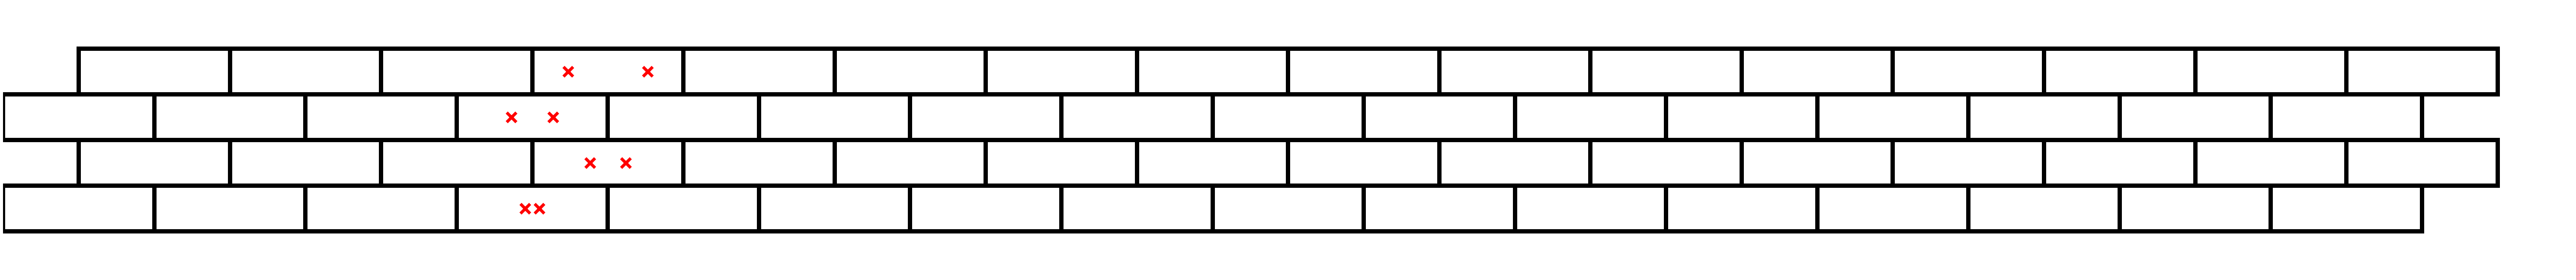

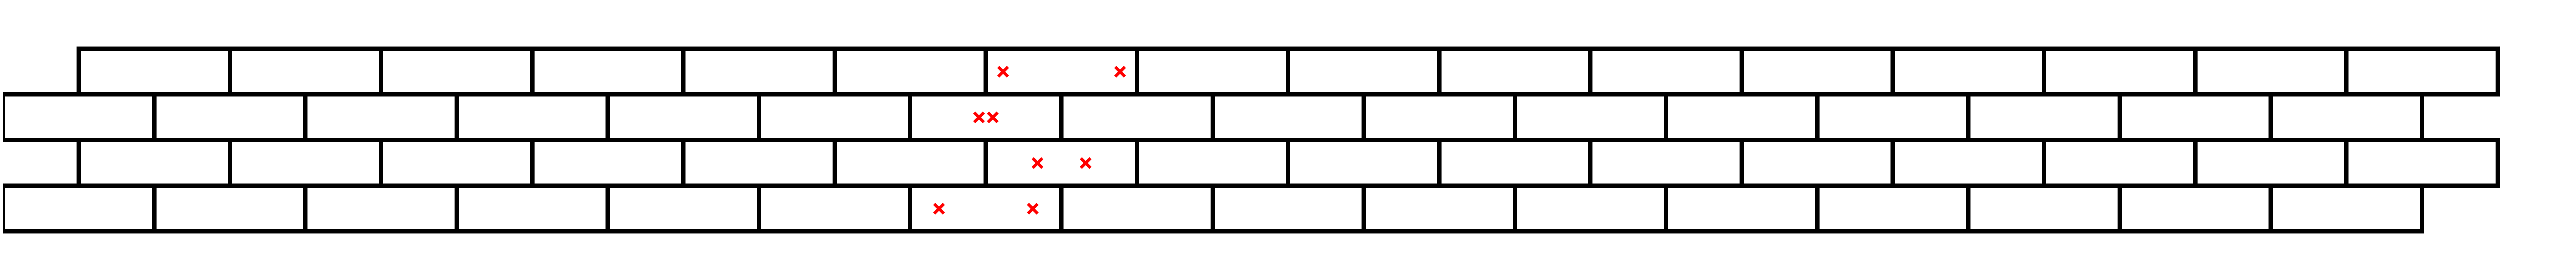

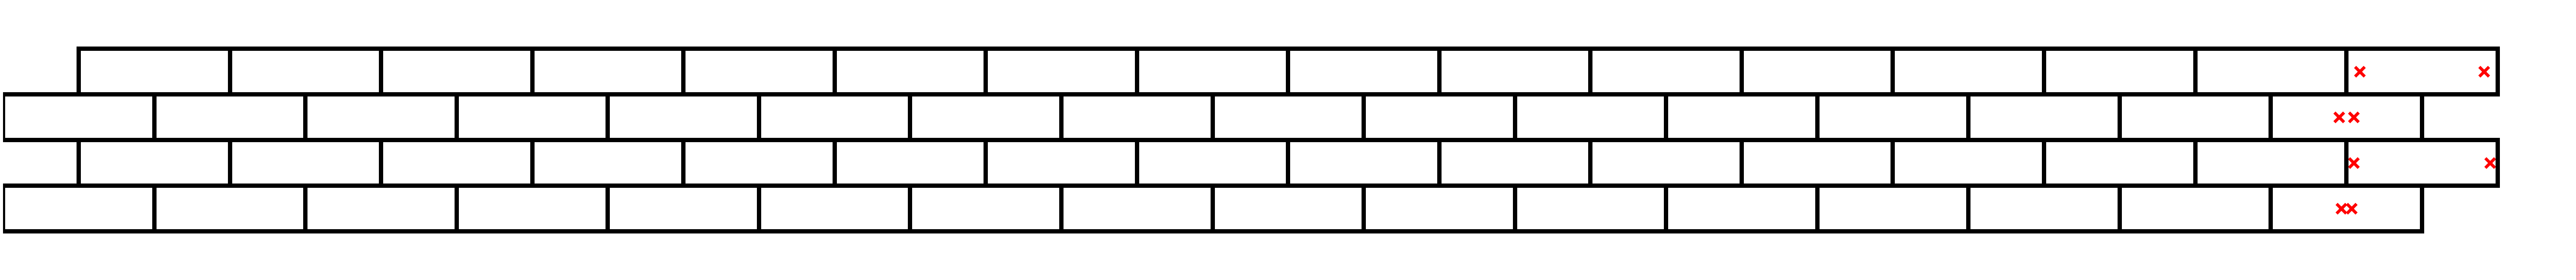

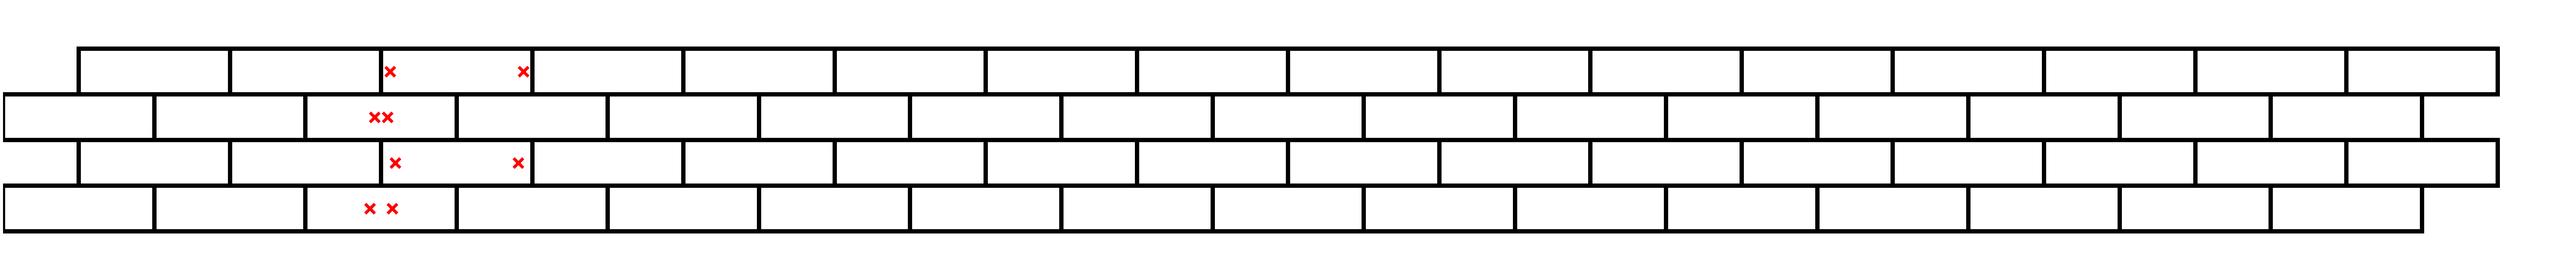

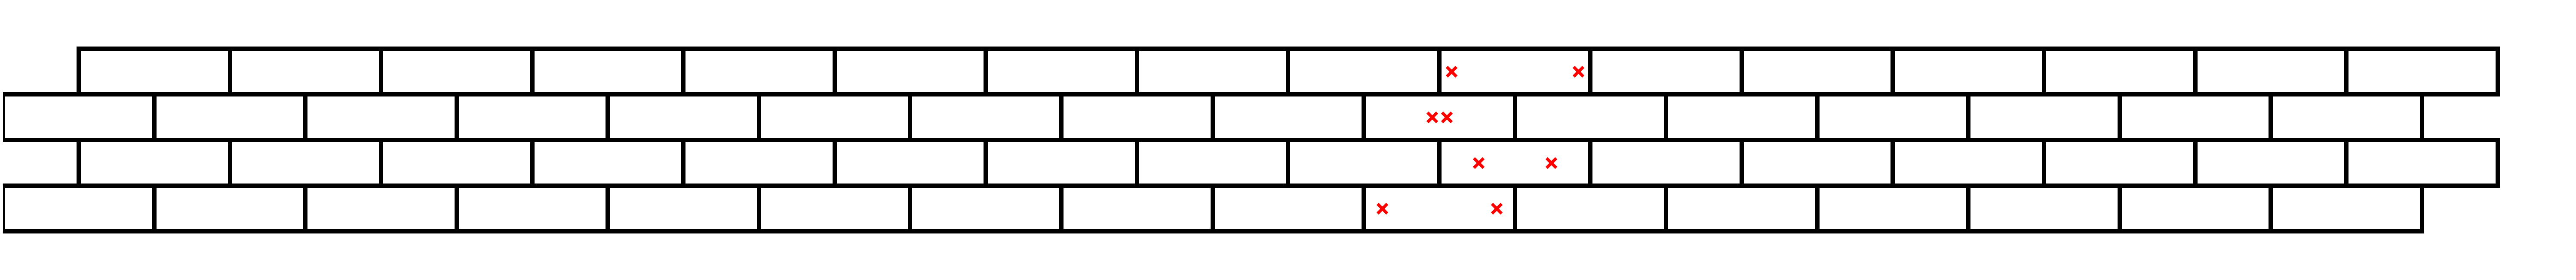

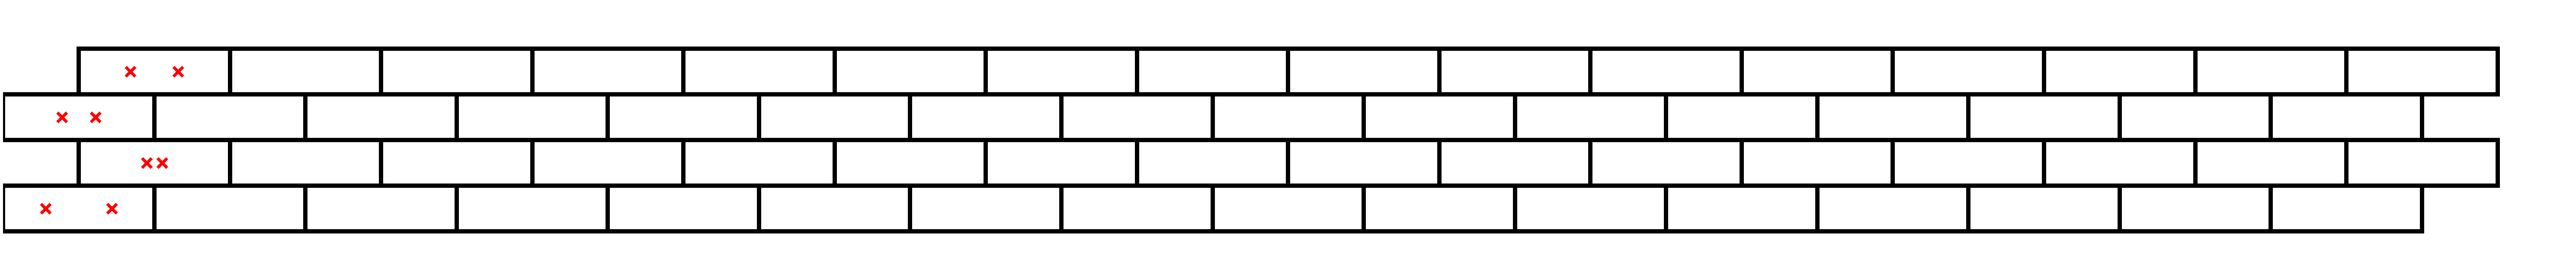

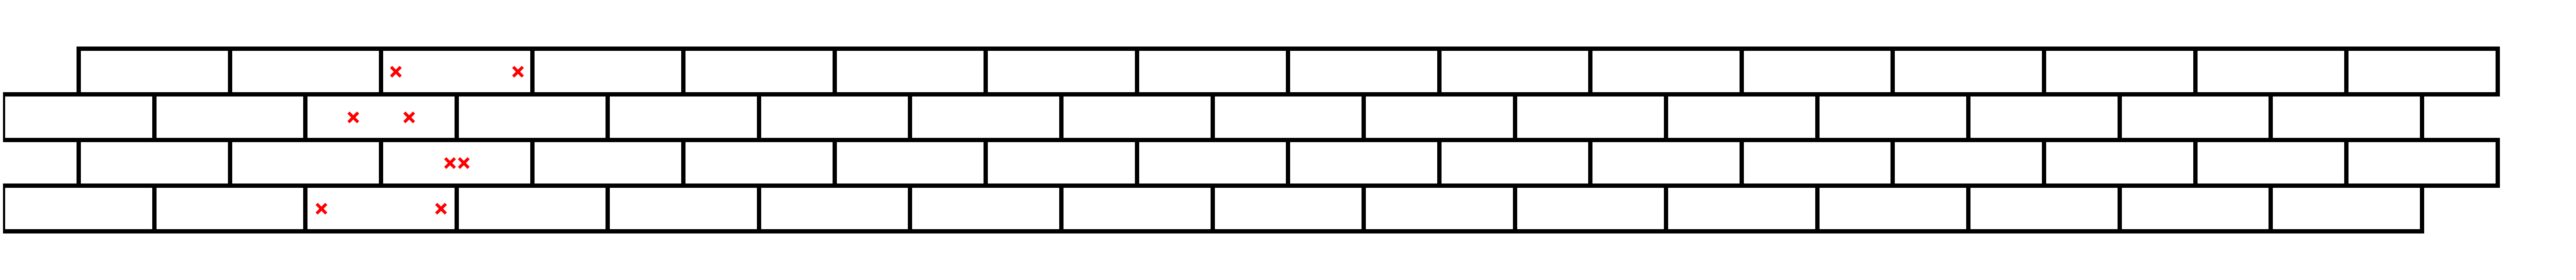

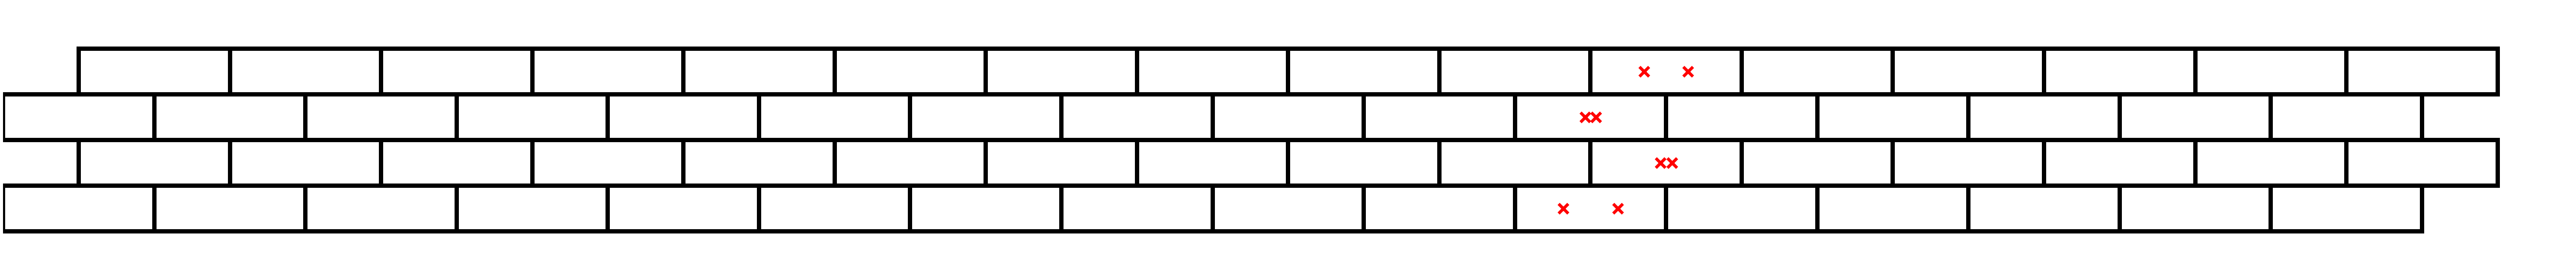

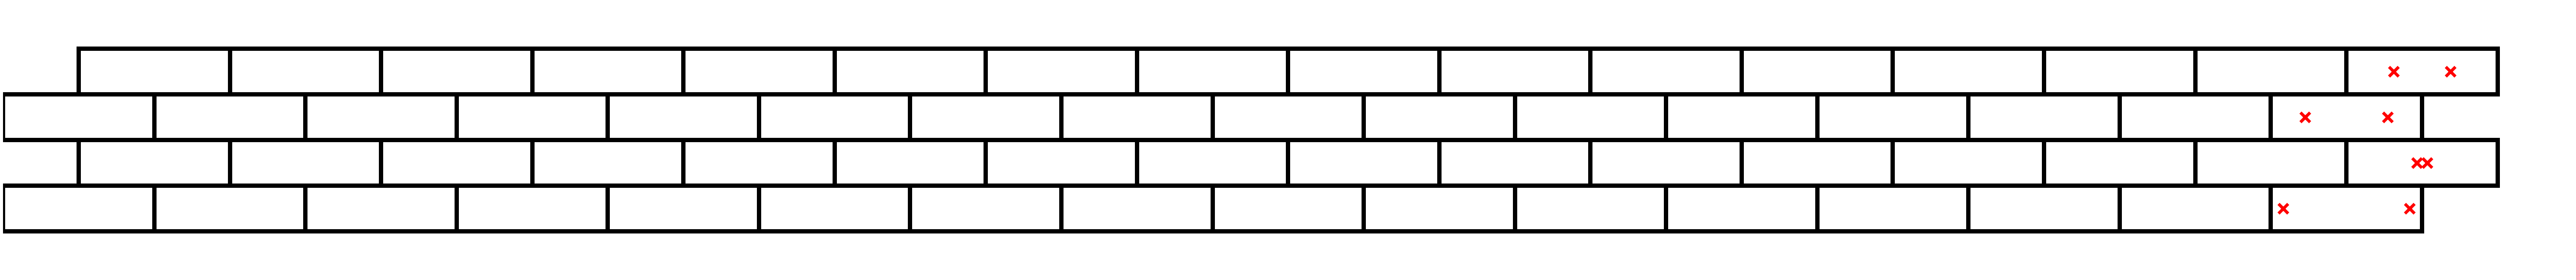

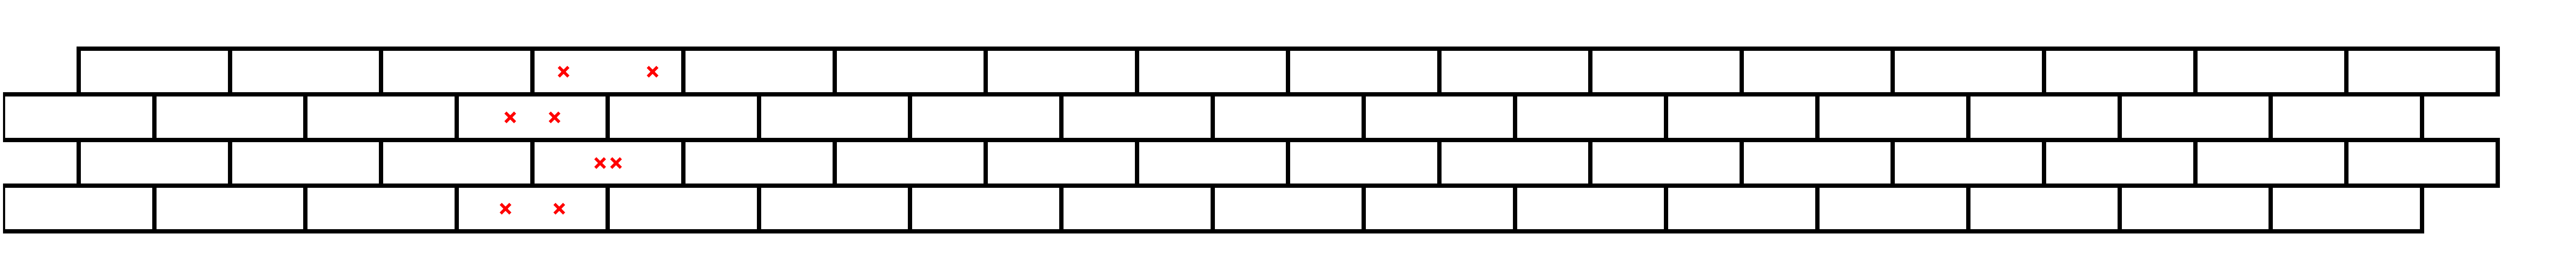

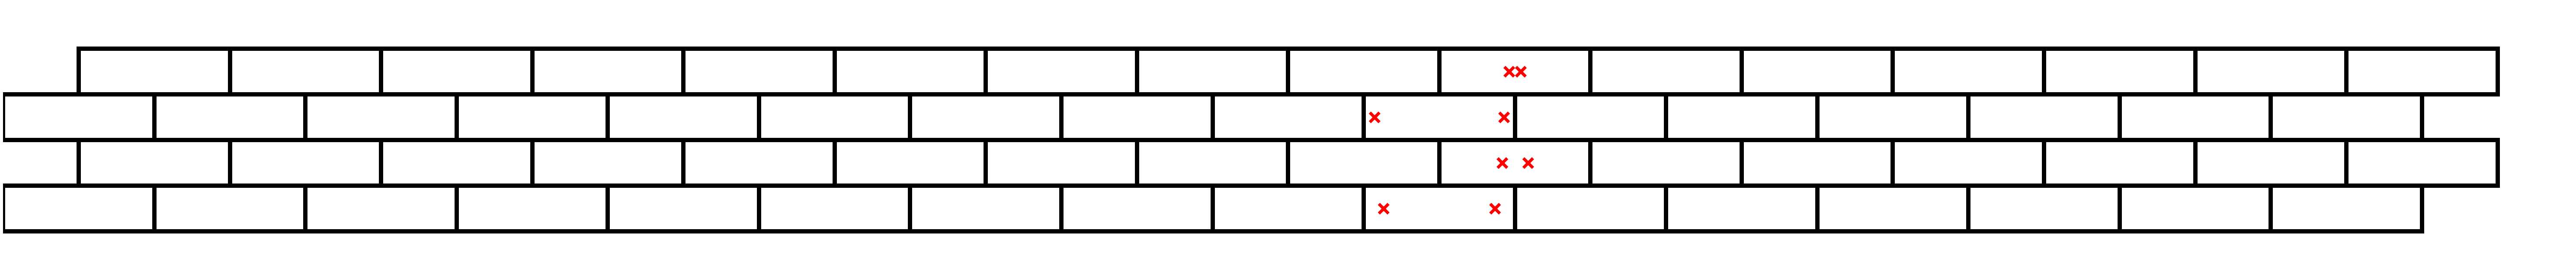

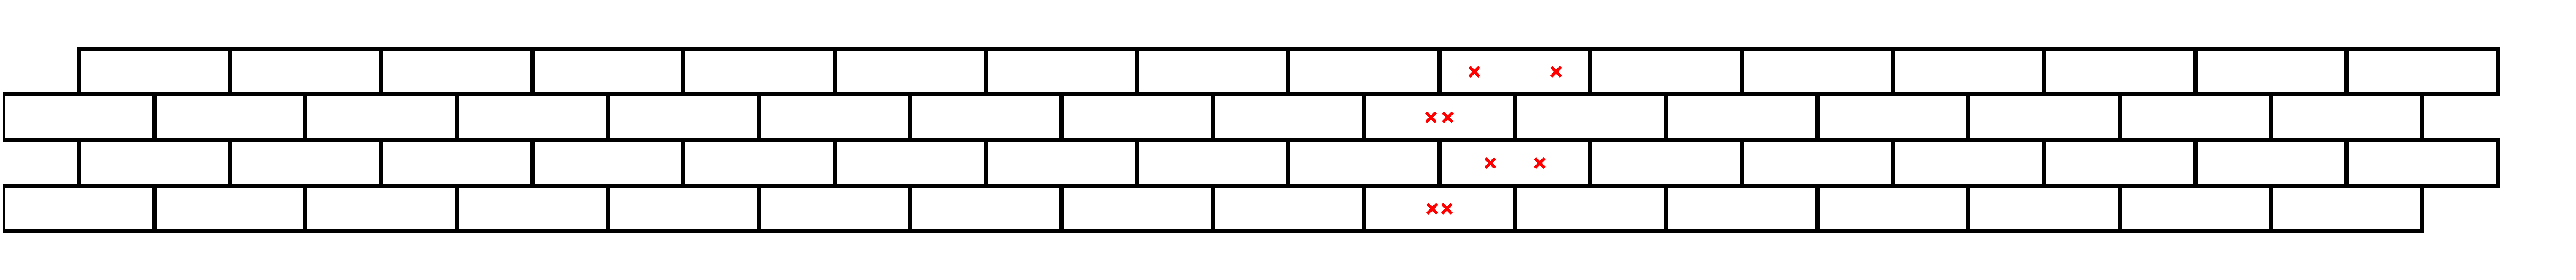

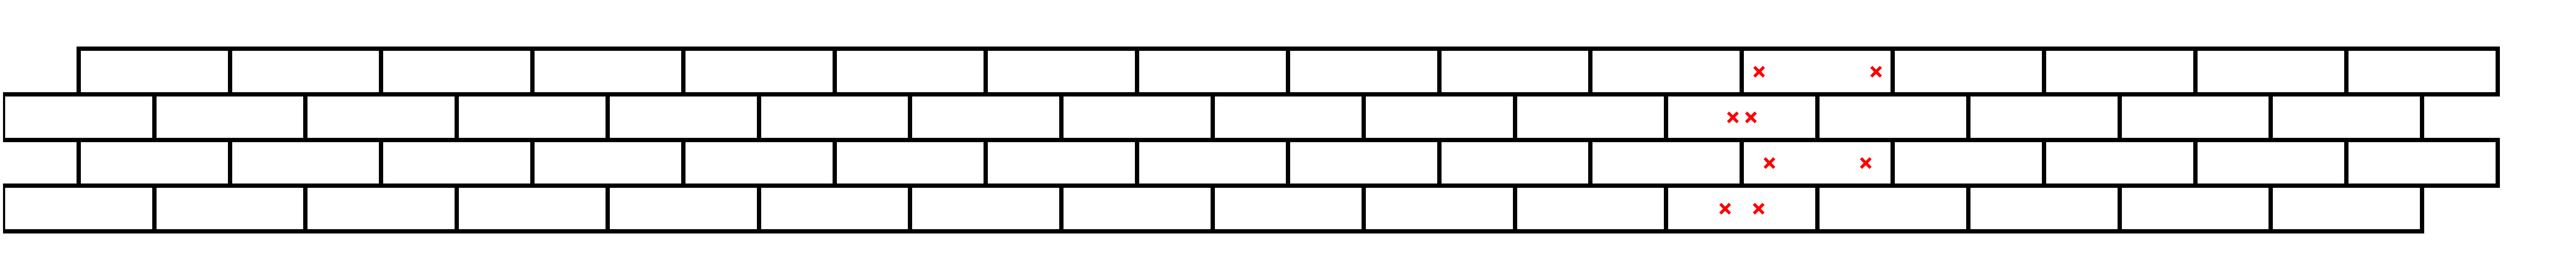

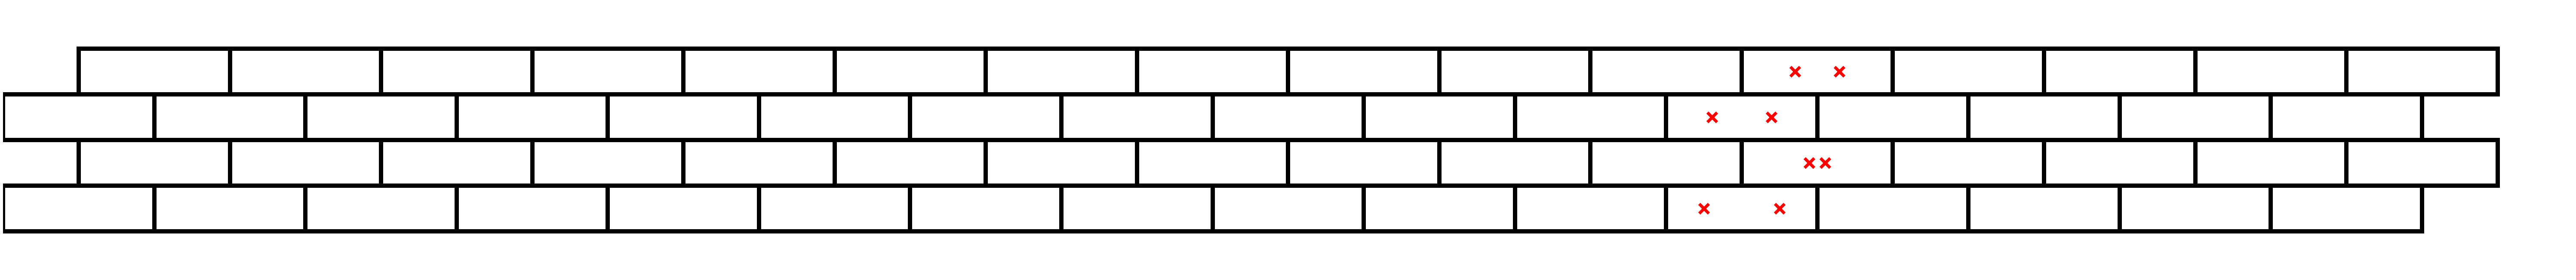

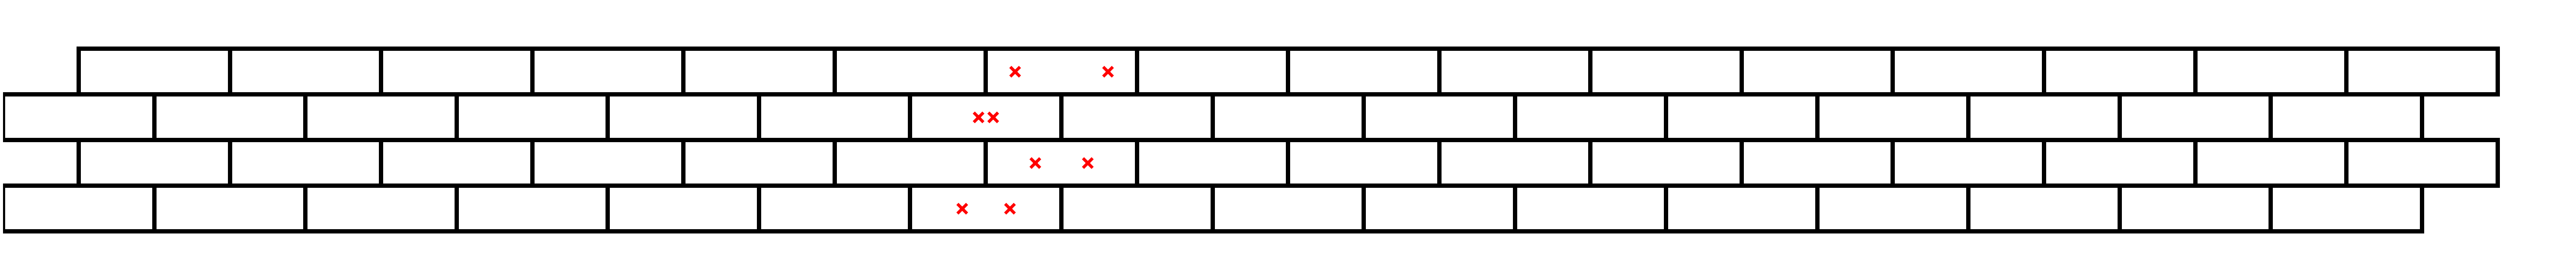

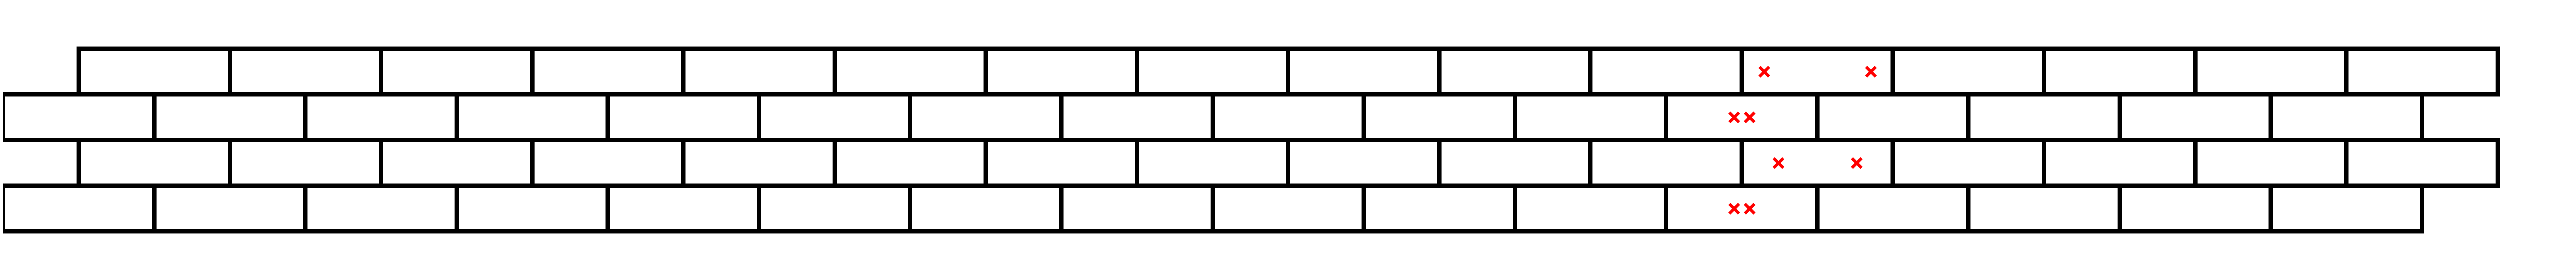

In [28]:
a = 0
for i in df.groupby(['ORBIT_CNT','EVENT']):
    
    if a > 15:
        break
    else:
        event_plot(i[1])
    a+=1


# About drift times density

With the constraints we assumed we required almost vertical trajectories, so in theory we should have uniform distribution for the drift times. But if we assume that choosing the electronic trigger as scintillator is the same thing as taking a random uniform time pedestal, we (see the figure below) should expect a distribution for which smaller values of drift time are more likely with respect to bigger drift time.

Text(0.5, 1.0, 'Theoretical distribution')

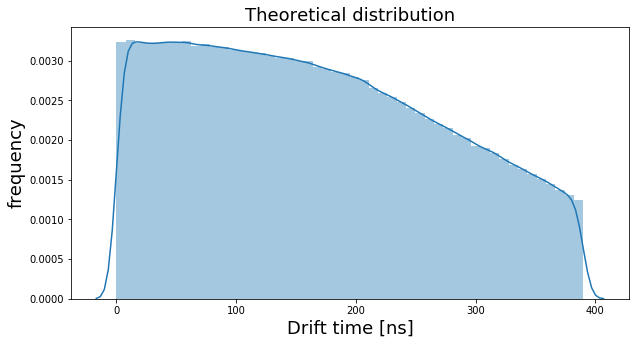

In [29]:
T = 390

sim_times = []
for i in range(1000000):
    
    #vertical trajectory
    l1 = l3 = np.random.rand(1)*T 
    l2 = l4 = np.abs(np.random.rand(1)-1)*T
    l = np.concatenate((l1, l2, l3, l4), axis = 0) 
    
    #assuming random time pedestal
    l = np.abs(l + (np.random.rand(1) - 1/2)*T)
    
    #we cannot have drift time bigget than T_max
    if (l > T).sum() == 0:
        sim_times.append(l)
        
sim_times = np.concatenate(sim_times)

fig,ax = plt.subplots(figsize = (10,5))
ax = seaborn.distplot(sim_times)
ax.set_xlabel('Drift time [ns]', fontsize = 18)
ax.set_ylabel('frequency', fontsize = 18)
ax.set_title('Theoretical distribution', fontsize = 18)

The assumption that taking the electronic trigger as scintillator is equivalent to assign a random uniform time pedestal is very strong. So we don't need to overlap the two figures (above and below) to see that the empirical distribution is not the same as the theoretical distribution. But we can see that it holds the fact that small values are more likely with respect big values.

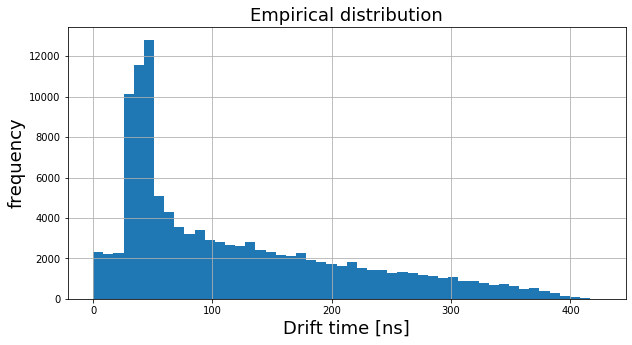

In [30]:
axarr = df.hist(column = 'DRIFT_TIME',bins=50, figsize = (10,5))

for ax in axarr.flatten():
    ax.set_xlabel('Drift time [ns]', fontsize = 18)
    ax.set_ylabel('frequency', fontsize = 18)
    ax.set_title('Empirical distribution', fontsize = 18)

# About execution time

Using pandas can be very useful: the risk of make errors writing the code is very small and the code is easily interpretable. The only problem is that for large dataset the groupby operations are very computationally expensive. It is not possibile with this execution time (see below) to run the algorithm for the 1500 physical datasets. We can optimize the code still grouping by orbits, but the better way (also a hard way) is not to do the computations grouping by orbits and use as long as possible the numpy values.

In [31]:
stop = time.time()
print("total execution time (s):", stop-start)

total execution time (s): 193.56223011016846


In [32]:
df.to_csv("dati_MM1.csv",index=False)